# Liquid biopsy benchmark

In [3]:
# Imports

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pysam
import warnings
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, roc_auc_score, precision_score, recall_score, average_precision_score
warnings.filterwarnings('ignore')
# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.viz import *

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [2]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
set_display_params(config)

prefix = 'dilution_chr22_'
chrom = '22'
dilutionseries = [(1,0), (1, 0.72), (0.75, 0.765), (0.5, 0.81), (0.25, 0.855), (0.125, 0.875)]

patient = '986'

if patient == '809':
    plasmasample1 = 'CRC-809_110914'
    plasmasample2 = 'CRC-809_030915'
    tumorsample1 = 'NCC_CRC-809_290714-T1W'
    plasmasampleltb = None
    healthysamples = ['pooledhealthy']
elif patient == '986':
    plasmasample1 = 'CRC-986_100215'
    plasmasample2 = 'CRC-986_261016'
    tumorsample1 = 'NCC_CRC-986_100215-T1W'
    plasmasampleltb = 'CRC-986_300316'
    healthysamples = ['pooledhealthy', 'pooledhealthy_986_filter_snv', plasmasampleltb]
elif patient == '1014':
    plasmasample1 = 'CRC-1014_180816'
    plasmasample2 = 'CRC-1014_110116'
    tumorsample1 = None
    plasmasampleltb = 'CRC-1014_090516'
    healthysamples = ['pooledhealthy', plasmasampleltb]

print(patient, healthysamples)

986 ['pooledhealthy', 'pooledhealthy_986_filter_snv', 'CRC-986_300316']


# Caller robustness: GT = calls detected by at least k callers in the undiluted liquid biopsy sample - SNV

In [ ]:
for healthysample in healthysamples:
    df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method=3, refsample='undiluted', chrom=chrom, muttype='SNV', tumorsample=None)
    figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='pr',  ground_truth_method=3, refsample='undiluted', chrom=chrom, muttype='SNV', save=True)
    figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='roc', ground_truth_method=3, refsample='undiluted', chrom=chrom, muttype='SNV', save=True)
    for m in config.methods:
        figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='pr',  ground_truth_method=3, refsample='undiluted', chrom=chrom, muttype='SNV', methods=[m], save=True)
        figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='roc', ground_truth_method=3, refsample='undiluted', chrom=chrom, muttype='SNV', methods=[m], save=True)

# Caller consistency: GT = calls detected by the same method in the undiluted liquid biopsy sample - SNV

In [ ]:
for healthysample in healthysamples:
    df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method='caller', refsample='undiluted', chrom='22', muttype='SNV', tumorsample=None)
    figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='roc', ground_truth_method='method', refsample='undiluted', chrom='22', muttype='SNV', save=True)
    figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='pr', ground_truth_method='method', refsample='undiluted', chrom='22', muttype='SNV', save=True)
    for m in config.methods:
        figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='pr',  ground_truth_method='method', refsample='undiluted', chrom=chrom, muttype='SNV', methods=[m], save=True)
        figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='roc', ground_truth_method='method', refsample='undiluted', chrom=chrom, muttype='SNV', methods=[m], save=True)

In [3]:
for healthysample in healthysamples:
    df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method='caller', refsample='undiluted', chrom='22', muttype='SNV', tumorsample=None)
    metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='precision', ground_truth_method='method',
                 refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=True)

data/bcbio_output/dilution_chr22_CRC-986_100215_1_pooledhealthy_0/dilution_chr22_CRC-986_100215_1_pooledhealthy_0-ensemble-annotated.vcf
select a single chrom = 22 for analysis
(1016, 16)
Index(['freebayes_truth', 'mutect2_truth', 'strelka2_truth', 'vardict_truth',
       'varscan_truth'],
      dtype='object')
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
vcf_pd_3 (0.5, 0.81)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.5_pooledhealthy_0.81/dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-ensemble-annotated.vcf
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis


KeyError: '8.332_freebayes'

In [ ]:
# Sample of interest
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*config.bcbiofolder, prefix + plasmasample1 + "_1_pooledhealthy_0", prefix + plasmasample1 + "_1_pooledhealthy_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, config.methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

results_df = pd.DataFrame()
aux_auprc = []
aux_auprcrelative = []
aux_method = []
aux_sample = []
aux_tb = []

baselineAUPRC = {}

for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*config.bcbiofolder, prefix+plasmasample1+"_"+str(d[0])+"_"+healthysample+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+healthysample+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, config.methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape)

            for method in config.methods:
                # GROUND TRUTH = calls detected by same method in undiluted sample
                y_true = pd.DataFrame(vcf_ref[[method+'_score']])
                y_true.columns = ['truth']
                y_true = y_true.astype(bool)
                df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis
                
                df_sample_method = df_sample[['truth', method+'_score']]#.dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method+'_score'].fillna(0, inplace=True)
                baselineAUPRC[method] = df_sample_method['truth'][df_sample_method['truth'] == True].shape[0]/df_sample_method['truth'].shape[0]
                aux_auprc.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']))
                aux_auprcrelative.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']) - baselineAUPRC[method])
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['AUPRC score'] = aux_auprc
results_df['AUPRC score - baseline AUPRC score'] = aux_auprcrelative
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
for method in config.methods:
    plt.axhline(y = baselineAUPRC[method], color = color_dict[method], linestyle = '--') 
sns.catplot(x="tumor burden", y="AUPRC score - baseline AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
plt.axhline(y = 0, color = 'k', linestyle = '--') 
#plt.ylim([-0.01, 1.01])

# Caller consistency: GT = calls detected by at least 2 methods in the matched tumor sample - SNV

In [ ]:
for healthysample in ['pooledhealthy', 'pooledhealthy_986_filter_snv', 'CRC-986_300316']:
    df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method=2, refsample='tumor', chrom='22', muttype='SNV', tumorsample=tumorsample1)
    figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='roc', ground_truth_method=2, refsample='tumor', chrom='22', muttype='SNV', save=True)
    figure_curve(config, df_table, plasmasample1, healthysample, dilutionseries, xy='pr', ground_truth_method=2, refsample='tumor', chrom='22', muttype='SNV', save=True)

# ROC curve - SNV - Caller consistency: GT = calls detected by the same method in the undiluted sample

In [ ]:
# GROUND TRUTH = consensus across 3 callers in undiluted sample
#vcf_path = os.path.join(*bcbiooutputdirpath, tumorsample1, tumorsample1+"-ensemble-annotated.vcf")
#vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
#vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']
y_true = pd.DataFrame(vcf_ref[config.methods_tissue].T.sum())
y_true.columns = ['truth']
y_true['truth'][y_true['truth'] < 3] = 0
y_true = y_true.astype(bool)
print(y_true.shape)

# Sample of interest
fig, ax = plt.subplots(figsize=(10,10))
for i, d in enumerate(dilutionseries):
    d0 = str(d[0]).replace('.', '_')
    d1 = str(d[1]).replace('.', '_')
    print('vcf_pd_'+str(i), d)
    vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
    vcf_sample = load_calls_from_vcf(vcf_path, config.methods_tissue, chrom=chrom)
    if vcf_sample is not None:
        vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
        print(vcf_sample.shape, y_true.shape)
        df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

        for method in config.methods_tissue:
            df_sample_method = df_sample[['truth', method + '_score']].dropna(how='all')
            #print(df_sample_method.shape)
            df_sample_method['truth'].fillna(False, inplace=True)
            df_sample_method[method + '_score'].fillna(0, inplace=True)
            precision, recall, thresholds = precision_recall_curve(df_sample_method['truth'], df_sample_method[method + '_score'])
            if i == 0:
                plot_pr_curve(precision, recall, estimator_name=method, f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha':alpha_dict[str(d)], 'lw':2})
            else:
                plot_pr_curve(precision, recall, estimator_name='', f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha': alpha_dict[str(d)], 'lw':2})
handles, labels = plt.gca().get_legend_handles_labels()
# Creating legend with color box
list_lines =  handles + [Line2D([0], [0], color='black', alpha=alpha_dict[str(i)], label='tumor burden = {:.2f}%'.format(100*tb_dict[str(i)])) for i in dilutionseries]
plt.legend(bbox_to_anchor=(1,1), loc="upper left", handles=list_lines)
plt.title("Precision Recall curve for SNV calling in sample {}".format(plasmasample1))
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

In [ ]:
# Sample of interest
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

results_df = pd.DataFrame()
aux_precision = []
aux_method = []
aux_sample = []
aux_tb = []

for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape)

            for method in config.methods:
                # GROUND TRUTH = calls detected by same method in undiluted sample
                y_true = pd.DataFrame(vcf_ref[[method]])
                y_true.columns = ['truth']
                y_true = y_true.astype(bool)
                df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

                df_sample_method = df_sample[['truth', method]].dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method].fillna(False, inplace=True)
                aux_precision.append(precision_score(df_sample_method['truth'], df_sample_method[method]))
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['precision'] = aux_precision
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="precision", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("Precision curve for SNV calling in sample {}".format(plasmasample1))
#plt.ylim([-0.01, 1.01])

In [ ]:
# Sample of interest
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

results_df = pd.DataFrame()
aux_precision = []
aux_method = []
aux_sample = []
aux_tb = []

for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape)

            for method in config.methods:
                # GROUND TRUTH = calls detected by same method in undiluted sample
                y_true = pd.DataFrame(vcf_ref[[method]])
                y_true.columns = ['truth']
                y_true = y_true.astype(bool)
                df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

                df_sample_method = df_sample[['truth', method]].dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method].fillna(False, inplace=True)
                aux_precision.append(recall_score(df_sample_method['truth'], df_sample_method[method]))
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['recall'] = aux_precision
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="recall", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("Recall curve for SNV calling in sample {}".format(plasmasample1))
#plt.ylim([-0.01, 1.01])

# F1-score plot

In [ ]:
# Sample of interest
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

results_df = pd.DataFrame()
aux_precision = []
aux_method = []
aux_sample = []
aux_tb = []

for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape)

            for method in config.methods:
                # GROUND TRUTH = calls detected by same method in undiluted sample
                y_true = pd.DataFrame(vcf_ref[[method]])
                y_true.columns = ['truth']
                y_true = y_true.astype(bool)
                df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

                df_sample_method = df_sample[['truth', method]].dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method].fillna(False, inplace=True)
                aux_precision.append(f1_score(df_sample_method['truth'], df_sample_method[method]))
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['F1-score'] = aux_precision
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="F1-score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("F1-score curve for SNV calling in sample {}".format(plasmasample1))
#plt.ylim([-0.01, 1.01])

# AUPRC plot

In [ ]:
# Sample of interest
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

results_df = pd.DataFrame()
aux_auprc = []
aux_auprcrelative = []
aux_method = []
aux_sample = []
aux_tb = []

baselineAUPRC = {}

for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape)

            for method in config.methods:
                # GROUND TRUTH = calls detected by same method in undiluted sample
                y_true = pd.DataFrame(vcf_ref[[method+'_score']])
                y_true.columns = ['truth']
                y_true = y_true.astype(bool)
                df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis
                
                df_sample_method = df_sample[['truth', method+'_score']]#.dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method+'_score'].fillna(0, inplace=True)
                baselineAUPRC[method] = df_sample_method['truth'][df_sample_method['truth'] == True].shape[0]/df_sample_method['truth'].shape[0]
                aux_auprc.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']))
                aux_auprcrelative.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']) - baselineAUPRC[method])
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['AUPRC score'] = aux_auprc
results_df['AUPRC score - baseline AUPRC score'] = aux_auprcrelative
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
for method in config.methods:
    plt.axhline(y = baselineAUPRC[method], color = color_dict[method], linestyle = '--') 
sns.catplot(x="tumor burden", y="AUPRC score - baseline AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
plt.axhline(y = 0, color = 'k', linestyle = '--') 
#plt.ylim([-0.01, 1.01])

In [ ]:

results_df = pd.DataFrame()
aux_auprc = []
aux_auprcrelative = []
aux_method = []
aux_sample = []
aux_tb = []

baselineAUPRC = {}

# GROUND TRUTH = consensus across 3 callers in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']
y_true = pd.DataFrame(vcf_ref[methods].T.sum())
y_true.columns = ['truth']
y_true['truth'][y_true['truth'] < 3] = 0
y_true = y_true.astype(bool)
print(y_true.shape)

# Sample of interest
for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape, y_true.shape)
            df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

            for method in config.methods:
                df_sample_method = df_sample[['truth', method+'_score']]#.dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method+'_score'].fillna(0, inplace=True)
                baselineAUPRC[method] = df_sample_method['truth'][df_sample_method['truth'] == True].shape[0]/df_sample_method['truth'].shape[0]
                aux_auprc.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']))
                aux_auprcrelative.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']) - baselineAUPRC[method])
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['AUPRC score'] = aux_auprc
results_df['AUPRC score - baseline AUPRC score'] = aux_auprcrelative
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
for method in config.methods:
    plt.axhline(y = baselineAUPRC[method], color = color_dict[method], linestyle = '--') 
sns.catplot(x="tumor burden", y="AUPRC score - baseline AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
plt.axhline(y = 0, color = 'k', linestyle = '--') 
#plt.ylim([-0.01, 1.01])

# Figures

In [4]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
set_display_params(config)

prefix = 'dilution_chr22_'
chrom = '22'
dilutionseries = [(1,0), (1, 0.72), (0.75, 0.765), (0.5, 0.81), (0.25, 0.855), (0.125, 0.875)]

patient = '986'

if patient == '809':
    plasmasample1 = 'CRC-809_110914'
    plasmasample2 = 'CRC-809_030915'
    tumorsample1 = 'NCC_CRC-809_290714-T1W'
    plasmasampleltb = None
    healthysamples = ['pooledhealthy']
elif patient == '986':
    plasmasample1 = 'CRC-986_100215'
    plasmasample2 = 'CRC-986_261016'
    tumorsample1 = 'NCC_CRC-986_100215-T1W'
    plasmasampleltb = 'CRC-986_300316'
    healthysamples = ['pooledhealthy', 'pooledhealthy_986_filter_snv', plasmasampleltb]
elif patient == '1014':
    plasmasample1 = 'CRC-1014_180816'
    plasmasample2 = 'CRC-1014_110116'
    tumorsample1 = None
    plasmasampleltb = 'CRC-1014_090516'
    healthysamples = ['pooledhealthy', plasmasampleltb]

print(patient, healthysamples)

986 ['pooledhealthy', 'pooledhealthy_986_filter_snv', 'CRC-986_300316']


data/bcbio_output/dilution_chr22_CRC-809_110914_1_pooledhealthy_0/dilution_chr22_CRC-809_110914_1_pooledhealthy_0-ensemble-annotated.vcf
select a single chrom = 22 for analysis
(1356, 16)
(590, 1)
Index(['truth'], dtype='object')
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
vcf_pd_3 (0.5, 0.81)
select a single chrom = 22 for analysis
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
{'freebayes': 0.10245310245310245, 'mutect2': 0.11973018549747048, 'strelka2': 0.11833333333333333, 'vardict': 0.11813643926788686, 'varscan': 0.11488673139158576}
[9.423, 9.423, 9.423, 9.423, 9.423, 7.069, 7.069, 7.069, 7.069, 7.069, 4.714, 4.714, 4.714, 4.714, 4.714, 2.358, 2.358, 2.358, 2.358, 2.358, 1.182, 1.182, 1.182, 1.182, 1.182]


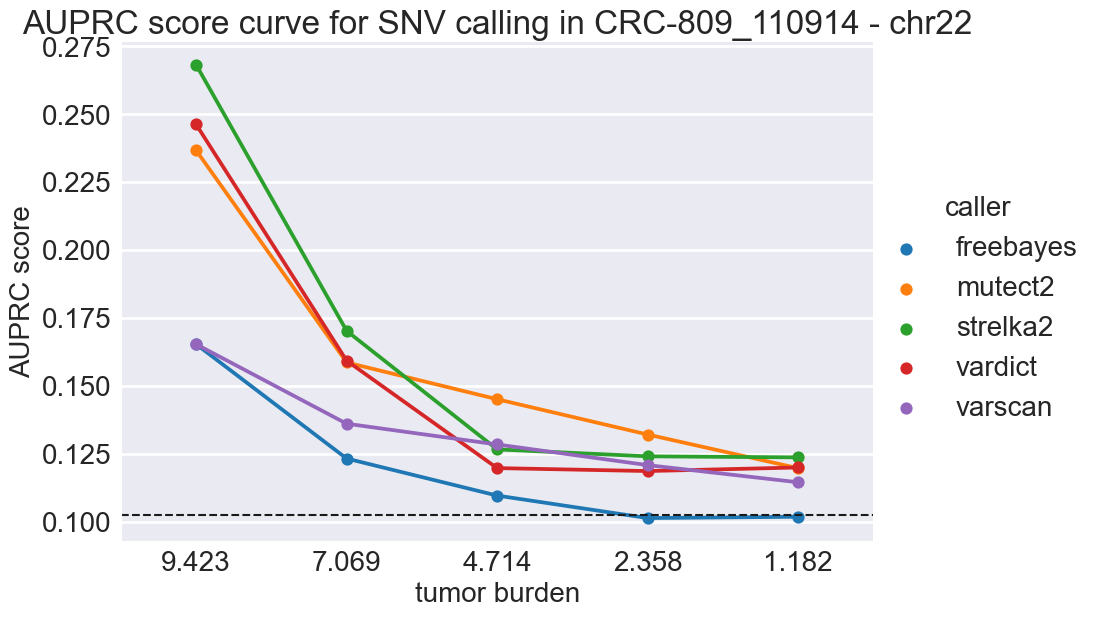

{'freebayes': 0.10245310245310245, 'mutect2': 0.11973018549747048, 'strelka2': 0.11833333333333333, 'vardict': 0.11813643926788686, 'varscan': 0.11488673139158576}
[9.423, 9.423, 9.423, 9.423, 9.423, 7.069, 7.069, 7.069, 7.069, 7.069, 4.714, 4.714, 4.714, 4.714, 4.714, 2.358, 2.358, 2.358, 2.358, 2.358, 1.182, 1.182, 1.182, 1.182, 1.182]


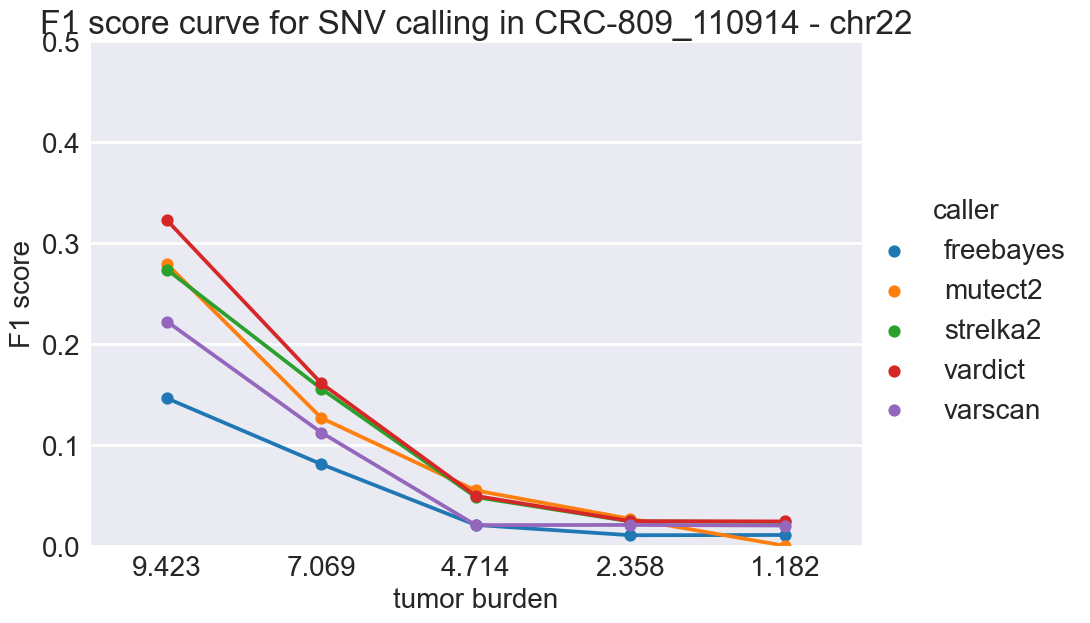

{'freebayes': 0.10245310245310245, 'mutect2': 0.11973018549747048, 'strelka2': 0.11833333333333333, 'vardict': 0.11813643926788686, 'varscan': 0.11488673139158576}
[9.423, 9.423, 9.423, 9.423, 9.423, 7.069, 7.069, 7.069, 7.069, 7.069, 4.714, 4.714, 4.714, 4.714, 4.714, 2.358, 2.358, 2.358, 2.358, 2.358, 1.182, 1.182, 1.182, 1.182, 1.182]


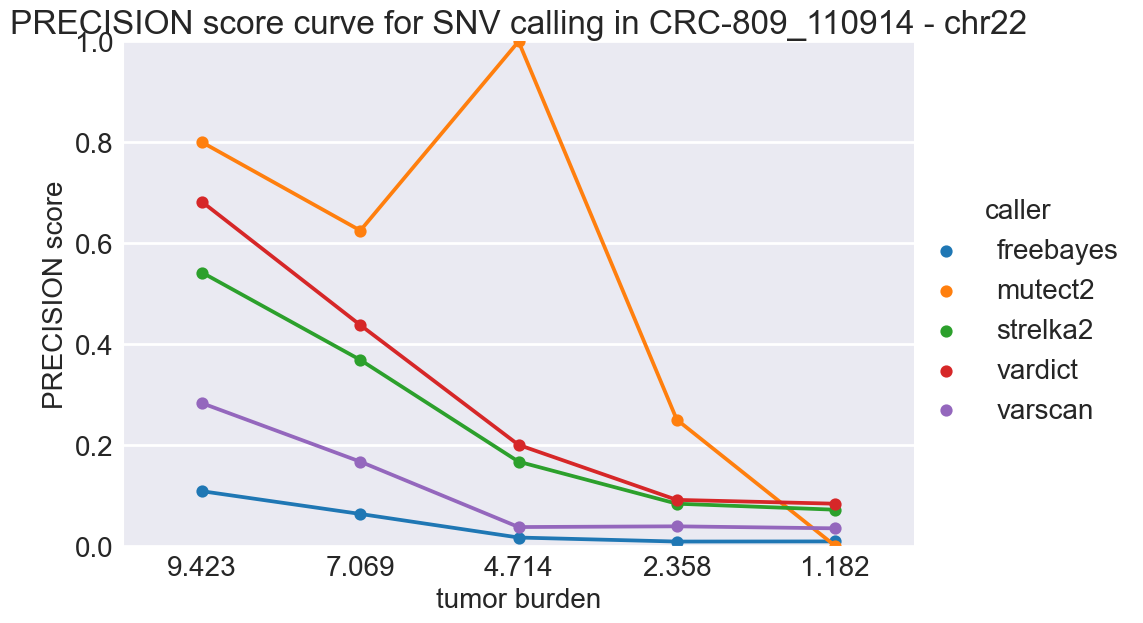

In [22]:
### CONSENSUS ###
healthysample = 'pooledhealthy' #plasmasampleltb
if patient == '1014':
    vcf_ref_path = 'data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf'
else:
    vcf_ref_path = None
df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method=4, refsample='undiluted', chrom='22', muttype='SNV', vcf_ref_path=vcf_ref_path)
metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='auprc', ground_truth_method=4, refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=True)
metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='f1', ground_truth_method=4, refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=True)
metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='precision', ground_truth_method=4, refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=True)

data/bcbio_output/dilution_chr22_CRC-986_100215_1_pooledhealthy_0/dilution_chr22_CRC-986_100215_1_pooledhealthy_0-ensemble-annotated.vcf
select a single chrom = 22 for analysis
(1016, 16)
Index(['freebayes_truth', 'mutect2_truth', 'strelka2_truth', 'vardict_truth',
       'varscan_truth'],
      dtype='object')
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
vcf_pd_3 (0.5, 0.81)
select a single chrom = 22 for analysis
vcf_pd_4 (0.25, 0.855)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.25_pooledhealthy_986_filter_snv_0.855/dilution_chr22_CRC-986_100215_0_25_pooledhealthy_986_filter_snv_0_855-ensemble-annotated.vcf
vcf_pd_5 (0.125, 0.875)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.125_pooledhealthy_986_filter_snv_0.875/dilution_chr22_CRC-986_100215_0_125_pooledhealthy_986_filter_snv_0_

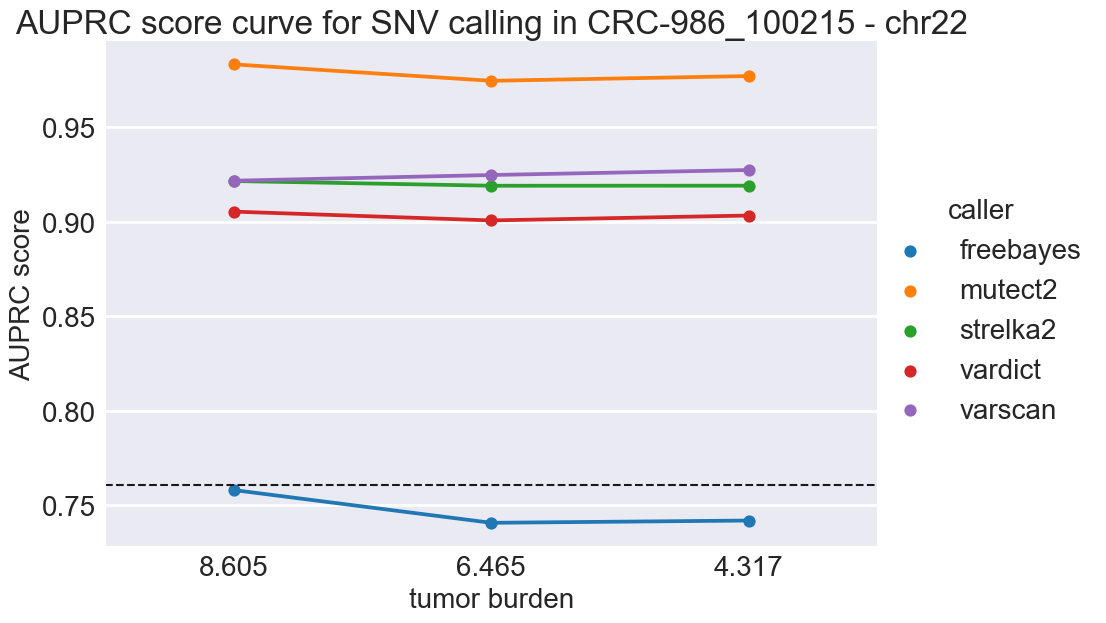

{'freebayes': 0.7606263982102909, 'mutect2': 0.9770114942528736, 'strelka2': 0.9264305177111717, 'vardict': 0.9066666666666666, 'varscan': 0.9340659340659341}
[8.605, 8.605, 8.605, 8.605, 8.605, 6.465, 6.465, 6.465, 6.465, 6.465, 4.317, 4.317, 4.317, 4.317, 4.317]


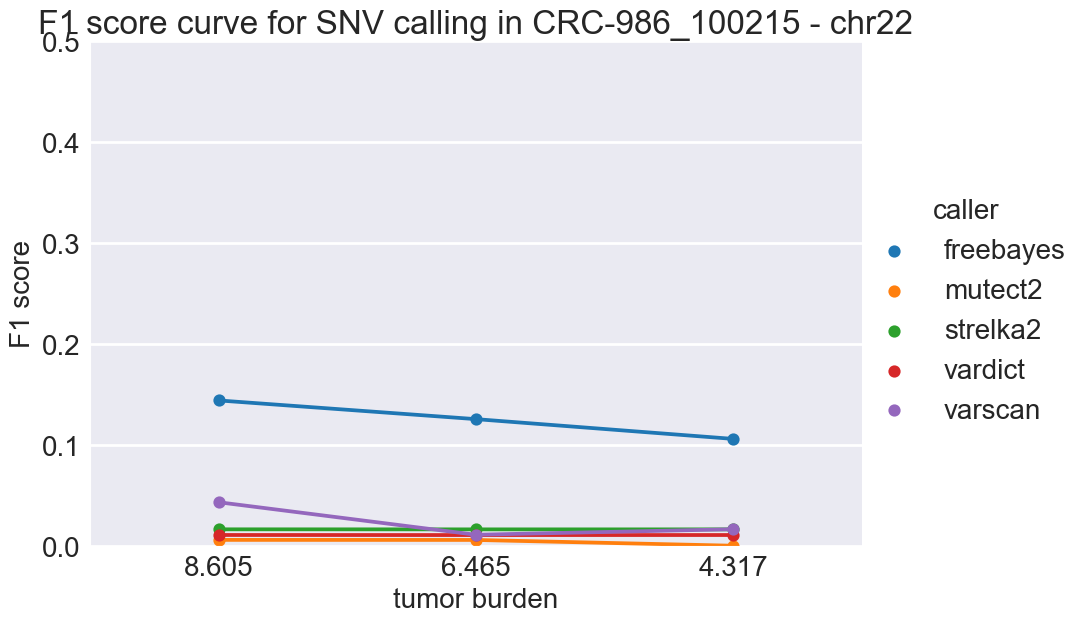

{'freebayes': 0.7606263982102909, 'mutect2': 0.9770114942528736, 'strelka2': 0.9264305177111717, 'vardict': 0.9066666666666666, 'varscan': 0.9340659340659341}
[8.605, 8.605, 8.605, 8.605, 8.605, 6.465, 6.465, 6.465, 6.465, 6.465, 4.317, 4.317, 4.317, 4.317, 4.317]


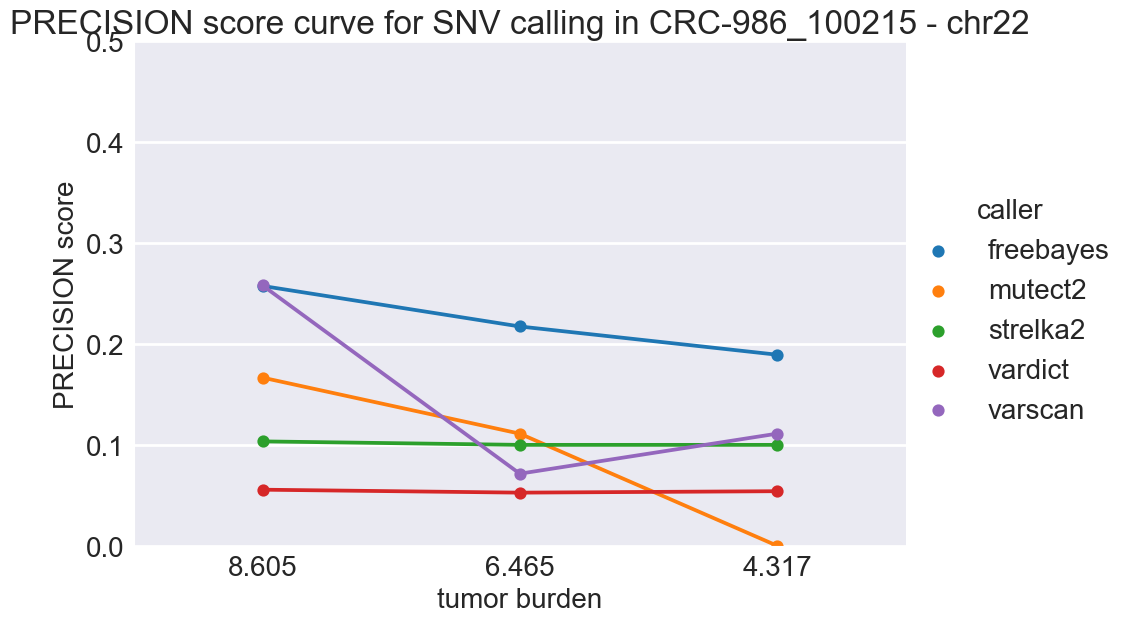

In [15]:
### CONSISTENCY ###
healthysample = 'pooledhealthy' #plasmasampleltb
if patient == '1014':
    vcf_ref_path = 'data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf'
else:
    vcf_ref_path = None
df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method='caller', refsample='undiluted', chrom='22', muttype='SNV', vcf_ref_path=vcf_ref_path)
metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='auprc', ground_truth_method='caller', refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=True)
metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='f1', ground_truth_method='caller', refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=True)
metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='precision', ground_truth_method='caller', refsample='undiluted', muttype='SNV', chrom='22', methods=None, save=True)

data/bcbio_output/NCC_CRC-986_100215-T1W/NCC_CRC-986_100215-T1W-ensemble-annotated.vcf
select a single chrom = 22 for analysis
(1769, 14)
(1373, 1)
Index(['truth'], dtype='object')
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
vcf_pd_3 (0.5, 0.81)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.5_pooledhealthy_0.81/dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-ensemble-annotated.vcf
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
             truth  8.332_freebayes_score
22_16050252   True                    0.0
22_16055570  False                    0.0
22_16060744   True                    0.0
22_16067349  False                    0.0
22_16067375  False                    0.0
22_16072799  False                    0.0
             truth  

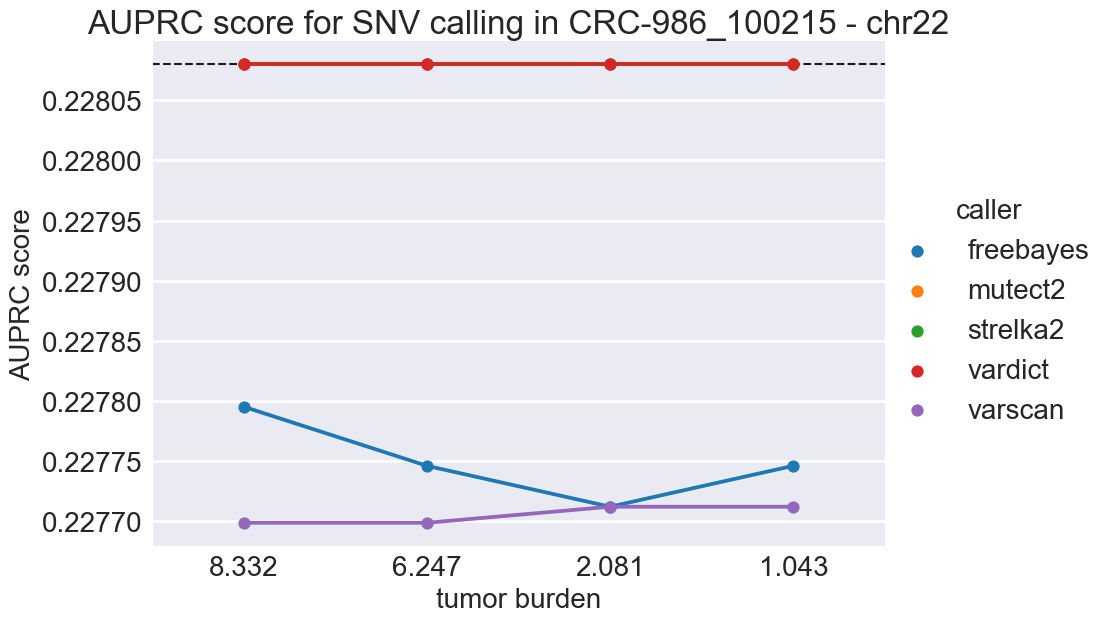

             truth  8.332_freebayes
22_16050252   True            False
22_16055570  False            False
22_16060744   True            False
22_16067349  False            False
22_16067375  False            False
22_16072799  False            False
             truth  8.332_mutect2
22_16050252   True          False
22_16055570  False          False
22_16060744   True          False
22_16067349  False          False
22_16067375  False          False
22_16072799  False          False
             truth  8.332_strelka2
22_16050252   True           False
22_16055570  False           False
22_16060744   True           False
22_16067349  False           False
22_16067375  False           False
22_16072799  False           False
             truth  8.332_vardict
22_16050252   True          False
22_16055570  False          False
22_16060744   True          False
22_16067349  False          False
22_16067375  False          False
22_16072799  False          False
             truth  8.332_v

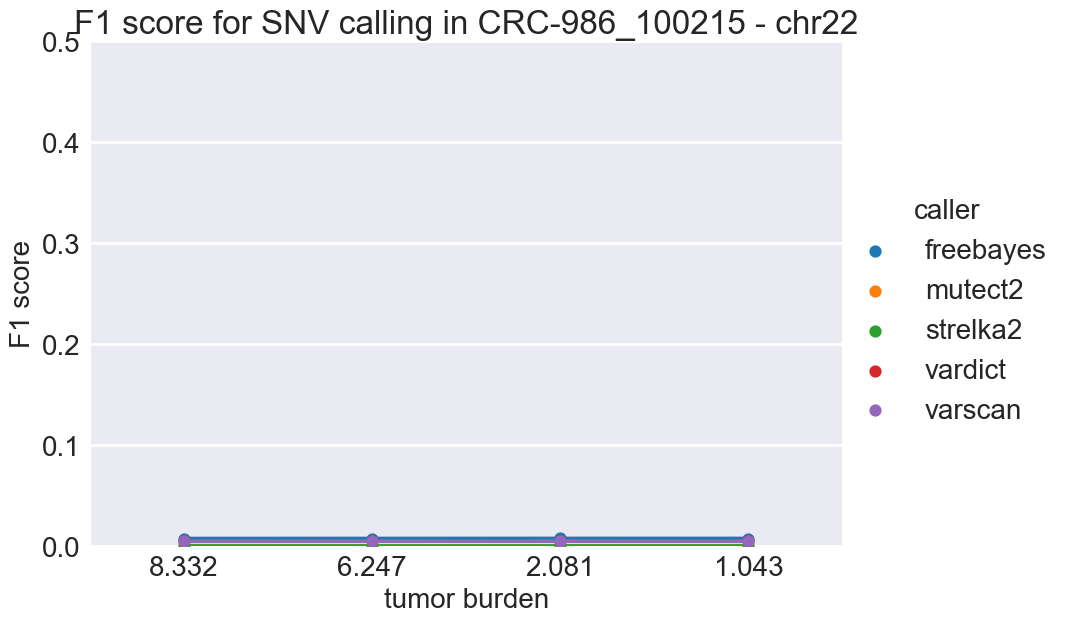

             truth  8.332_freebayes
22_16050252   True            False
22_16055570  False            False
22_16060744   True            False
22_16067349  False            False
22_16067375  False            False
22_16072799  False            False
22_16050252    False
22_16060744    False
22_16148732    False
22_16148871    False
22_16161139    False
               ...  
22_50536619    False
22_50536627    False
22_50536628    False
22_50624775    False
22_51238130    False
Name: 8.332_freebayes, Length: 411, dtype: bool
             truth  8.332_mutect2
22_16050252   True          False
22_16055570  False          False
22_16060744   True          False
22_16067349  False          False
22_16067375  False          False
22_16072799  False          False
22_16050252    False
22_16060744    False
22_16148732    False
22_16148871    False
22_16161139    False
               ...  
22_50536619    False
22_50536627    False
22_50536628    False
22_50624775    False
22_51238130    False


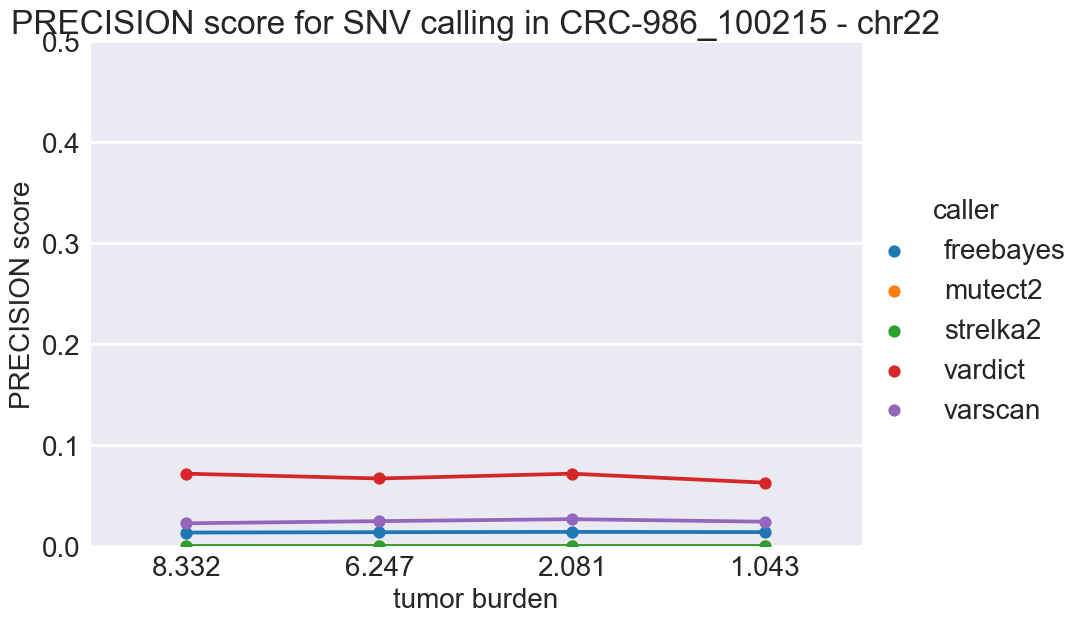

In [6]:
## TUMOR ###
healthysample = 'pooledhealthy' #plasmasampleltb
if patient != '1014':
    df_table = get_call_table(config, prefix, plasmasample1, healthysample, dilutionseries, ground_truth_method=2, refsample='tumor', chrom='22', muttype='SNV', tumorsample=tumorsample1, vcf_ref_path=None)
    metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='auprc', ground_truth_method=2, refsample='tumor', muttype='SNV', chrom='22', methods=None, save=True)
    metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='f1', ground_truth_method=2, refsample='tumor', muttype='SNV', chrom='22', methods=None, save=True)
    metric_curve(config, df_table, plasmasample1, healthysample, dilutionseries, metric='precision', ground_truth_method=2, refsample='tumor', muttype='SNV', chrom='22', methods=None, save=True)